# WebRender dashboard ETL script

You probably want to look at the [published dashboard](file:///Users/tsmith/projects/webrender-dashboard/dashboard.html).

You can check [scheduled run status](https://dbc-caf9527b-e073.cloud.databricks.com/#job/715).


### What's different?

* Metrics are summarized by build (vs date).
* Performance metrics are aggregated over users; this is important because it reduces the impacts of outlier users on our understanding of product performance, and because it reflects how WebRender changes the user experience at the user level.
* Pings are artisanally hand-selected so that comparisons between experiment branches are fair even in the presence of the various enrollment weirdnesses.

In [2]:
%r
library(boot)
library(dplyr, warn.conflicts=FALSE)
library(ggplot2)
library(sparklyr, warn.conflicts=FALSE)
library(tidyr, warn.conflicts=FALSE)

sc = spark_connect(method="databricks")

# Save result tables so we can access them from hala


In [3]:
from moztelemetry.dataset import Dataset
import pandas as pd
from pyspark.sql import Row
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, BooleanType, IntegerType, DoubleType, LongType, MapType
from statsmodels.stats.weightstats import DescrStatsW

EXPERIMENT_ID = "prefflip-webrender-v1-2-1492568"
EXPERIMENT_ID_2 = "prefflip-webrender-v1-3-1492568"
PARTITIONS = [s.replace("-", "_") for s in (EXPERIMENT_ID, EXPERIMENT_ID_2)]

In [4]:
to_summarize = {
  "composite_time": "payload.processes.gpu.histograms.COMPOSITE_TIME",
  "content_frame_time": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME",
  "content_frame_time_svg": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME_WITH_SVG",
  "content_frame_time_reason": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME_REASON",
  "content_frame_time_without_upload": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME_WITHOUT_UPLOAD",
  "content_paint_time": "payload.processes.content.histograms.CONTENT_PAINT_TIME",
  "tab_switch_composite": "payload.histograms.FX_TAB_SWITCH_COMPOSITE_E10S_MS",
  "content_full_paint_time": "payload.processes.gpu.histograms.CONTENT_FULL_PAINT_TIME",
  "page_load_ms": "payload.histograms.FX_PAGE_LOAD_MS_2"
}

to_pull = {}
for k, v in to_summarize.items():
  to_pull[k] = v + ".values"
  to_pull[k + "_sum"] = v + ".sum"

pings = (
  Dataset
  .from_source("telemetry-cohorts")
  .where(
    docType="main",
    experimentId=lambda x: x in PARTITIONS,
  )
  .select(
    app_build_id="application.buildId",
    branch='environment.experiments."%s".branch' % EXPERIMENT_ID,
    branch2='environment.experiments."%s".branch' % EXPERIMENT_ID_2,
    gfx_info='environment.system.gfx',
    gfx_description="environment.system.gfx.adapters[0].description",
    client_id="clientId",
    gfx_compositor="environment.system.gfx.features.compositor",
    normalized_channel="meta.normalizedChannel",
    profile_subsession_counter="payload.info.profileSubsessionCounter",
    session_id="payload.info.sessionId",
    target_pref_value='environment.settings.userPrefs."gfx.webrender.all.qualified"',
    # ---
    device_reset_reason_content="payload.processes.content.histograms.DEVICE_RESET_REASON.values",
    device_reset_reason_gpu="payload.processes.gpu.histograms.DEVICE_RESET_REASON.values",
    device_reset_reason_parent="payload.histograms.DEVICE_RESET_REASON.values",
    subsession_length="payload.info.subsessionLength",
    active_ticks='payload.processes.parent.scalars."browser.engagement.active_ticks"',
    total_uris='payload.processes.parent.scalars."browser.engagement.total_uri_count"',
    **to_pull
  )
  .records(sc)
)

def ping_to_row(x):
  for k, v in to_summarize.items():
    x[k + "_count"] = sum((x[k] or {}).values())
  
  x["experiment"] = (x["branch"] and 2) or 3
  x["branch"] = x["branch"] or x["branch2"]
  del x["branch2"]
  
  # Aggregate DEVICE_RESET_REASON for crash rates
  procs = ("parent", "content", "gpu")
  x["device_reset_reason_total"] = 0
  for proc in procs:
    key = "device_reset_reason_" + proc
    x[key + "_count"] = sum((x[key] or {}).values())
    x["device_reset_reason_total"] += x[key + "_count"]
    del x[key]
  
  # Calculate usage hours for crash rates
  # Based on https://github.com/mozilla/telemetry-streaming/blob/ee2eafd18a8b12a3fafca496d58789f641069bf6/src/main/scala/com/mozilla/telemetry/pings/MainPing.scala#L71-L82
  subsession_length = x["subsession_length"] or 0
  x["usage_hours"] = max(min(subsession_length/3600., 25.), 0.)
  return Row(**x)

fetching 164863.91982MB in 68194 files...

In [5]:
#def 
pings = pings.filter(lambda p: len(p["gfx_info"]["monitors"]) == 1 and p["gfx_info"]["monitors"][0]["refreshRate"] == 60)

In [6]:
sdf_fields = [
  StructField("app_build_id", StringType(), True),
  StructField("branch", StringType(), False),
  StructField("client_id", StringType(), False),
  StructField("experiment", IntegerType(), False),
  StructField("gfx_compositor", StringType(), True),
  StructField("gfx_description", StringType(), True),
  StructField("normalized_channel", StringType(), True),
  StructField("profile_subsession_counter", LongType(), True),  
  StructField("session_id", StringType(), True),
  StructField("target_pref_value", BooleanType(), True),
  StructField("device_reset_reason_parent_count", LongType(), True),
  StructField("device_reset_reason_content_count", LongType(), True),
  StructField("device_reset_reason_gpu_count", LongType(), True),
  StructField("device_reset_reason_total", LongType(), True),
  StructField("active_ticks", LongType(), True),
  StructField("total_uris", LongType(), True),
  StructField("subsession_length", LongType(), True),
  StructField("usage_hours", DoubleType(), True),
]

for k, v in to_summarize.items():
  sdf_fields.extend([
    StructField(k, MapType(StringType(), LongType()), True),
    StructField(k + "_sum", LongType(), True),
    StructField(k + "_count", LongType(), True),
  ])

sdf = spark.createDataFrame(pings.map(ping_to_row), schema=StructType(sdf_fields))

In [7]:
sdf.cache()
None

In [8]:
# Because compositor changes don't take effect until the browser restarts,
# we should discard the enrollment session we observe for each client.
# We'll find those sessions here, and then anti-join against this table later.

first_sessions = (
  sdf
  .orderBy(sdf.experiment, sdf.client_id, sdf.branch, sdf.profile_subsession_counter)
  .groupBy(sdf.experiment, sdf.client_id, sdf.branch)
  .agg(
    f.first(sdf.session_id).alias("session_id"),
  )
)

In [9]:
# Broadcast joins time-out unless the cluster is warm
spark.sql("SET spark.sql.autoBroadcastJoinThreshold = -1")

subsessions = (
  sdf
  .join(first_sessions, on=["experiment", "client_id", "branch", "session_id"], how="left_anti")
  .where(sdf.target_pref_value.isNotNull())
  .where(
    ((sdf.branch == "disabled") & (sdf.gfx_compositor == "d3d11"))
    | ((sdf.branch == "enabled") & (sdf.gfx_compositor == "webrender"))
  )
  .where(
    (sdf.normalized_channel == "beta") | (sdf.normalized_channel == "nightly")
  )
  .cache()
)

In [10]:
subsessions.createOrReplaceGlobalTempView("webrender_metrics")

In [11]:
# Compute per-user quantiles for CONTENT_PAINT_TIME

def generate_quantile_udf(sdf, grouping_fields, bucket_field, count_field, quantiles):
  """
  sdf: Spark DataFrame
  grouping_fields: list of strings representing columns from sdf
  bucket_field: Name of the field containing histogram buckets
  count_field: Name of the field containing counts
  quantiles: List of quantiles as floating point values on [0, 1]
  """
  schema = (
    sdf
    .select(*grouping_fields)
    .schema
    .add(StructField("quantile", DoubleType(), False))
    .add(StructField("value", DoubleType(), True))
  )
  
  @f.pandas_udf(schema, f.PandasUDFType.GROUPED_MAP)
  def udf(df):
    stats = DescrStatsW(df[bucket_field].astype(float), df[count_field]).quantile(quantiles)
    stats = stats.rename_axis("quantile").reset_index(name="value").assign(_dummy=1)
    grouping_variables = df[grouping_fields].iloc[:1].assign(_dummy=1)
    result = grouping_variables.merge(stats, on="_dummy").drop("_dummy", axis=1)
    return result
  
  return udf

metric_quantiles = generate_quantile_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  quantiles=[0.5, 0.9, 0.95, 0.99]
)

paint_time_quantiles = (
  subsessions
  .select(
    subsessions.client_id,
    subsessions.branch,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(subsessions.content_paint_time).alias("bucket", "count")
  )
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel, "bucket")
  .agg(f.sum("count").alias("count"))
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
  .apply(metric_quantiles)
)

paint_time_quantiles.createOrReplaceGlobalTempView("wr_paint_time_quantiles")

In [12]:
  schema = (
    sdf
    .select(*["client_id", "app_build_id", "normalized_channel", "branch"])
    .schema
    #.add(StructField("branch", StringType(), False))
    .add(StructField("threshold", IntegerType(), False))
    .add(StructField("fraction_exceeding", DoubleType(), True))
  )
  
  schema2 = (
    sdf
    .select(*["client_id", "app_build_id", "normalized_channel"])
    .schema
    .add(StructField("branch", StringType(), False))
    .add(StructField("threshold", IntegerType(), False))
    .add(StructField("fraction_exceeding", DoubleType(), True))
  )
  schema == schema2

Out[ 31 ]: True

In [13]:
# Changes to CONTENT_FRAME_TIME are only user-visible when CONTENT_FRAME_TIME exceeds 200.
# Count the fraction of CONTENT_FRAME_TIME events where the threshold is exceeded.
# (The threshold is set to 192 because of the binning of the histogram.)

def generate_threshold_udf(sdf, grouping_fields, bucket_field, count_field, thresholds):
  """
  sdf: Spark DataFrame
  grouping_fields: list of strings representing columns from sdf
  bucket_field: Name of the field containing histogram buckets
  count_field: Name of the field containing counts
  thresholds: List of thresholds. Should probably align on the left edge of a bucket.
  """
  schema = (
    sdf
    .select(*grouping_fields)
    .schema
    .add(StructField("branch", StringType(), False))
    .add(StructField("threshold", IntegerType(), False))
    .add(StructField("fraction_exceeding", DoubleType(), True))
  )
  
  @f.pandas_udf(schema, f.PandasUDFType.GROUPED_MAP)
  def udf(df):
    rows = []
    all_sum = float(df[count_field].sum())
    for tx in thresholds:
      fraction = df.loc[df[bucket_field].astype(int) >= tx, count_field].sum() / all_sum
      rows.append({"threshold": tx, "fraction_exceeding": fraction})
    data = pd.DataFrame(rows).assign(_dummy=1)
    grouping_variables = df[["client_id", "app_build_id", "normalized_channel", "branch"]].iloc[:1].assign(_dummy=1)
    result = grouping_variables.merge(data, on="_dummy").drop("_dummy", axis=1)
    return result
  
  return udf

vsync_threshold = generate_threshold_udf(
  subsessions,
  ["client_id", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  thresholds=[192],
)

slow_content_frame_time = (
  subsessions
  .select(
    subsessions.client_id,
    "branch",
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(subsessions.content_frame_time).alias("bucket", "count")
  )
  .groupBy(subsessions.client_id, "branch", subsessions.app_build_id, subsessions.normalized_channel)
  .apply(vsync_threshold)
)

slow_content_frame_time.createOrReplaceGlobalTempView("wr_slow_content_frame_time")

In [14]:
# Changes to CONTENT_FRAME_TIME are only user-visible when CONTENT_FRAME_TIME exceeds 200.
# Count the fraction of CONTENT_FRAME_TIME events where the threshold is exceeded.
# (The threshold is set to 192 because of the binning of the histogram.)

def subtract_svg(branch, x, y):
  if x and y:
    no_svg = dict(x)
    #assert(branch == "enabled")
    for k in y.keys():
      if k in no_svg:
        no_svg[k] -= y[k]
    return {branch:x, branch + "nosvg": no_svg};
  return {branch: x}

frame_time = udf(subtract_svg, MapType(StringType(), MapType(StringType(), IntegerType(), True), True))


slow_content_frame_time_svg = (
  subsessions
  #.filter("branch == 'enabled'")
  .select(
    subsessions.client_id,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(frame_time("branch", subsessions.content_frame_time, subsessions.content_frame_time_svg)).alias("branch", "timing")
  )
  .select(
    subsessions.client_id,
    "branch",
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode("timing").alias("bucket", "count"),
  )
  .groupBy(subsessions.client_id, "branch", subsessions.app_build_id, subsessions.normalized_channel)
  .apply(vsync_threshold)
)
#slow_content_frame_time_svg.take(1)
#slow_content_frame_time_svg.filter("branch != 'enabled'").take(100)
#help(slow_content_frame_time)

slow_content_frame_time_svg.createOrReplaceGlobalTempView("wr_slow_content_frame_time_svg")

In [15]:
# Changes to CONTENT_FRAME_TIME are only user-visible when CONTENT_FRAME_TIME exceeds 200.
# Count the fraction of CONTENT_FRAME_TIME events where the threshold is exceeded.
# (The threshold is set to 192 because of the binning of the histogram.)

def no_upload(branch, x, y):
  if x and y:
    return {branch:x, branch + "noupload": y};
  return {branch: x}

frame_time = udf(no_upload, MapType(StringType(), MapType(StringType(), IntegerType(), True), True))


slow_content_frame_time_without_upload = (
  subsessions
  #.filter("branch == 'enabled'")
  .select(
    subsessions.client_id,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(frame_time("branch", subsessions.content_frame_time, subsessions.content_frame_time_without_upload)).alias("branch", "timing")
  )
  .select(
    subsessions.client_id,
    "branch",
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode("timing").alias("bucket", "count"),
  )
  .groupBy(subsessions.client_id, "branch", subsessions.app_build_id, subsessions.normalized_channel)
  .apply(vsync_threshold)
)
#slow_content_frame_time_without_upload.take(1)
#slow_content_frame_time_svg.filter("branch != 'enabled'").take(100)
#help(slow_content_frame_time)

slow_content_frame_time_without_upload.createOrReplaceGlobalTempView("wr_slow_content_frame_time_without_upload")

In [16]:
def countBadPaints(x):
  reasonPaints = 0
  timePaints = 0
  for (k, v) in x['content_frame_time_reason'].iteritems():
    if k != '0':
      reasonPaints += v
  for (k, v) in x['content_frame_time'].iteritems():
    if int(k) >= 192:
      timePaints += v
  return (reasonPaints, timePaints)

#subsessions.filter("normalized_channel != 'beta'").filter("app_build_id == '20181222095037'").filter("branch = 'enabled'").rdd.filter(lambda x:  #x['content_frame_time_reason']).map(countBadPaints).take(8)

In [17]:
#subsessions.select("app_build_id").groupBy("app_build_id").count().sort("app_build_id").take(400)

In [18]:
reasons = ["OnTime", "NoVsync", "MissedComposite", "SlowComposite", "MissedCompositeMid", "MissedCompositeLong", "MissedCompositeLow", "NA"];
reasons_summary = ["OnTime", "NoVsync", "MissedComposite", "SlowComposite", "MissedComposite", "MissedComposite", "MissedComposite", "NA"];
reason_name = udf(lambda x: reasons_summary[int(x)], StringType())

reasons = (subsessions.filter("normalized_channel != 'beta'")
  #.filter("branch = 'enabled'")
  .select(f.explode('content_frame_time_reason').alias("reason", "count"), 'app_build_id', 'branch')
  .select("count",'app_build_id','branch', reason_name("reason").alias("reason"))

  .groupBy("app_build_id", "branch", "reason").agg(
    f.sum("count").alias("count"),
  )
  #.filter("reason != 'OnTime'")
  .filter("app_build_id = '20190106095006'")
 )
reasons.cache()
reasons.createOrReplaceGlobalTempView("wr_reasons")

In [19]:
reason_names = ["OnTime", "NoVsync", "MissedComposite", "SlowComposite", "MissedCompositeMid", "MissedCompositeLong", "MissedCompositeLow", "NA"];

def intkeys(x):
  return {int(key):value for (key,value) in x.items()}

def majority(x):
  ctfr = x['content_frame_time_reason']
  if not ctfr:
    return (0, 0)
  slow = 0
  if '3' in ctfr:
    slow += ctfr['3']
  missed = 0
  for i in ctfr.iteritems():
    if i[0] in ('2', '4', '5', '6'):
      missed += i[1]
  return (slow, missed, {reason_names[int(key)]:value for (key, value) in ctfr.items()}, intkeys(x['content_frame_time']), x['gfx_description'], intkeys(x['content_full_paint_time']))

map(majority, subsessions.filter("normalized_channel != 'beta'").select('content_frame_time_reason', 'content_full_paint_time', 'content_frame_time', 'gfx_description').filter("app_build_id == '20181224215145'").rdd.take(100))

Out[ 38 ]: 
[(0,
 12,
 {'MissedComposite': 12, 'OnTime': 11712, 'SlowComposite': 0},
 {7: 0,
 8: 1,
 9: 4,
 11: 2,
 13: 44,
 15: 18,
 18: 7,
 21: 8,
 25: 5,
 29: 5,
 34: 21,
 40: 25,
 47: 44,
 55: 97,
 64: 196,
 75: 601,
 88: 8534,
 103: 1740,
 120: 162,
 140: 40,
 164: 123,
 192: 44,
 224: 1,
 262: 2,
 306: 0},
 u'NVIDIA GeForce GTX 1060 6GB',
 {0: 50,
 1: 2020,
 2: 2763,
 3: 2377,
 4: 840,
 5: 813,
 6: 1428,
 7: 636,
 8: 286,
 9: 147,
 10: 67,
 11: 53,
 12: 100,
 14: 46,
 16: 30,
 18: 25,
 20: 52,
 23: 34,
 26: 15,
 29: 7,
 33: 1,
 42: 1,
 47: 0}),
 (33,
 6202,
 {'MissedComposite': 3,
 'MissedCompositeLong': 2678,
 'MissedCompositeLow': 20,
 'MissedCompositeMid': 3501,
 'NA': 0,
 'NoVsync': 59,
 'OnTime': 54209,
 'SlowComposite': 33},
 {11: 0,
 13: 1,
 15: 9,
 18: 8,
 21: 29,
 25: 44,
 29: 71,
 34: 109,
 40: 175,
 47: 313,
 55: 597,
 64: 1104,
 75: 1989,
 88: 4623,
 103: 25801,
 120: 15273,
 140: 2773,
 164: 980,
 192: 2555,
 224: 3620,
 262: 305,
 306: 86,
 357: 12,
 417: 8,
 487: 8,
 569: 3,
 665: 3,
 777: 1,
 907: 1,
 1059: 1,
 1237: 1,
 1445: 0},
 u'NVIDIA GeForce GTX 1080',
 {0: 205,
 1: 8376,
 2: 8760,
 3: 5280,
 4: 5067,
 5: 5597,
 6: 8285,
 7: 6707,
 8: 5190,
 9: 4197,
 10: 3226,
 11: 3014,
 12: 4938,
 14: 2746,
 16: 1961,
 18: 1563,
 20: 1608,
 23: 704,
 26: 297,
 29: 140,
 33: 48,
 37: 19,
 42: 6,
 47: 2,
 53: 1,
 60: 1,
 67: 2,
 75: 1,
 84: 0}),
 (7,
 0,
 {'MissedCompositeMid': 0, 'OnTime': 330, 'SlowComposite': 7},
 {8: 0,
 9: 1,
 34: 2,
 40: 2,
 47: 2,
 64: 6,
 75: 3,
 88: 10,
 103: 278,
 120: 20,
 140: 3,
 164: 3,
 224: 1,
 665: 1,
 777: 2,
 907: 1,
 1237: 2,
 1445: 0},
 u'NVIDIA GeForce GTX 460',
 {0: 7,
 1: 348,
 2: 225,
 3: 68,
 4: 45,
 5: 15,
 6: 8,
 7: 12,
 8: 6,
 9: 2,
 10: 1,
 11: 1,
 37: 1,
 42: 0}),
 (0,
 19,
 {'MissedComposite': 19, 'NoVsync': 4, 'OnTime': 8035, 'SlowComposite': 0},
 {11: 0,
 13: 1,
 15: 4,
 18: 1,
 21: 24,
 25: 3,
 29: 4,
 34: 9,
 40: 4,
 47: 12,
 55: 24,
 64: 71,
 75: 392,
 88: 3707,
 103: 3738,
 120: 13,
 140: 11,
 164: 12,
 192: 16,
 224: 8,
 262: 2,
 417: 1,
 665: 1,
 777: 0},
 u'NVIDIA GeForce GTX 650',
 {0: 5,
 1: 32,
 2: 451,
 3: 1595,
 4: 3077,
 5: 2013,
 6: 550,
 7: 169,
 8: 66,
 9: 25,
 10: 13,
 11: 10,
 12: 10,
 14: 14,
 16: 13,
 18: 8,
 20: 8,
 23: 3,
 26: 4,
 29: 2,
 33: 2,
 37: 2,
 42: 2,
 47: 1,
 67: 1,
 107: 1,
 120: 0}),
 (8,
 4,
 {'MissedComposite': 2,
 'MissedCompositeLong': 1,
 'MissedCompositeLow': 0,
 'MissedCompositeMid': 1,
 'NoVsync': 2,
 'OnTime': 600,
 'SlowComposite': 8},
 {18: 0,
 21: 5,
 25: 6,
 29: 9,
 34: 4,
 40: 13,
 47: 11,
 55: 15,
 64: 10,
 75: 21,
 88: 75,
 103: 375,
 120: 35,
 140: 15,
 164: 3,
 192: 4,
 224: 5,
 262: 1,
 306: 2,
 357: 1,
 777: 2,
 1059: 1,
 1688: 1,
 1971: 0},
 u'NVIDIA GeForce GTX 960',
 {0: 93,
 1: 1208,
 2: 372,
 3: 126,
 4: 62,
 5: 27,
 6: 8,
 7: 9,
 8: 5,
 9: 3,
 10: 7,
 11: 2,
 12: 4,
 14: 2,
 16: 2,
 26: 1,
 42: 1,
 171: 2,
 216: 1,
 243: 0}),
 (10,
 56,
 {'MissedComposite': 56,
 'MissedCompositeMid': 0,
 'NoVsync': 10,
 'OnTime': 3130,
 'SlowComposite': 10},
 {2: 0,
 3: 1,
 4: 1,
 5: 2,
 6: 2,
 7: 1,
 8: 3,
 9: 15,
 11: 36,
 13: 26,
 15: 11,
 18: 19,
 21: 15,
 25: 17,
 29: 20,
 34: 14,
 40: 20,
 47: 14,
 55: 30,
 64: 49,
 75: 224,
 88: 1496,
 103: 993,
 120: 37,
 140: 33,
 164: 37,
 192: 40,
 224: 12,
 262: 14,
 306: 8,
 357: 6,
 417: 4,
 487: 1,
 569: 1,
 665: 1,
 777: 2,
 1059: 1,
 1237: 0},
 u'NVIDIA GeForce GTX 960',
 {0: 121,
 1: 689,
 2: 758,
 3: 524,
 4: 300,
 5: 241,
 6: 158,
 7: 74,
 8: 62,
 9: 44,
 10: 24,
 11: 37,
 12: 59,
 14: 23,
 16: 26,
 18: 27,
 20: 20,
 23: 13,
 26: 15,
 29: 11,
 33: 13,
 37: 10,
 42: 11,
 47: 11,
 53: 10,
 60: 3,
 67: 4,
 75: 5,
 84: 4,
 95: 1,
 107: 1,
 135: 1,
 152: 1,
 171: 0}),
 (2,
 9,
 {'MissedComposite': 9,
 'MissedCompositeMid': 0,
 'NoVsync': 2,
 'OnTime': 2529,
 'SlowComposite': 2},
 {3: 0,
 4: 2,
 8: 2,
 9: 5,
 11: 8,
 13: 9,
 15: 11,
 18: 16,
 21: 15,
 25: 16,
 29: 6,
 34: 16,
 40: 13,
 47: 20,
 55: 37,
 64: 79,
 75: 235,
 88: 1336,
 103: 624,
 120: 38,
 140: 27,
 164: 13,
 

In [20]:
#reasons.take(5)

In [21]:
%r
reasons = tbl(sc, "global_temp.wr_reasons")
reasons$reason

NULL

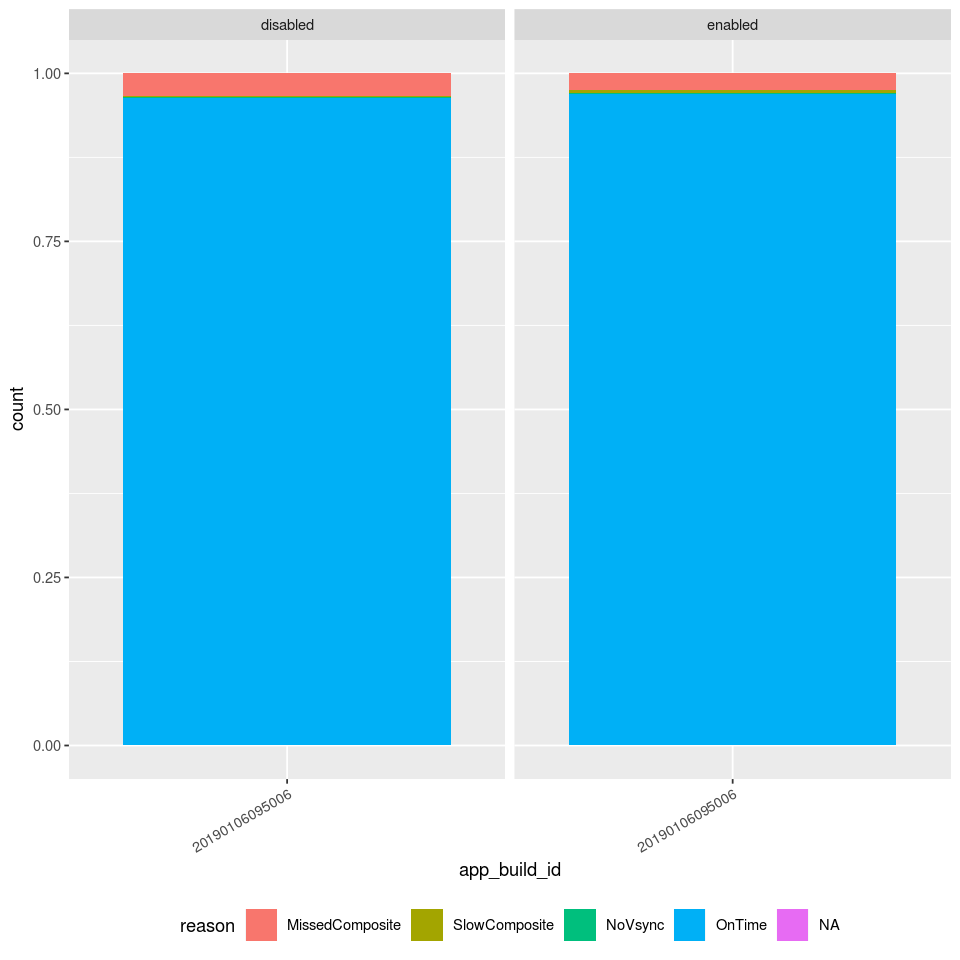

In [22]:
%r

p <- reasons %>% 
   ggplot(aes(app_build_id, count, fill=factor(reason, levels=c("MissedComposite", "MissedCompositeLow", "MissedCompositeMid", "MissedCompositeLong", "SlowComposite", "NoVsync",  "OnTime", "NA"))))+
    geom_col(position=position_fill()) +
    scale_fill_discrete("reason") +
    facet_grid(~branch, scales="free_x", space="free_x") +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +  theme(legend.position="bottom")
p


In [23]:
recent = reasons.filter("app_build_id == '20181224215145'").rdd
total = recent.map(lambda x: x['count']).sum()
recent.map(lambda x: (x['reason'], 100.*x['count']/total)).take(300)


Out[ 19 ]: 
[(u'MissedCompositeMid', 0.0),
 (u'MissedComposite', 2.0145907977018984),
 (u'NoVsync', 10.038250536752406),
 (u'MissedCompositeMid', 16.20710883582283),
 (u'MissedCompositeLong', 21.037283615025316),
 (u'SlowComposite', 17.62756289680882),
 (u'SlowComposite', 3.311323216182893),
 (u'MissedComposite', 26.28782207275958),
 (u'NoVsync', 2.7205971381163274),
 (u'NA', 0.0),
 (u'MissedCompositeLow', 0.7554608908299326)]

In [24]:
# Summarize instances of other performance metrics exceeding 16ms

# to_summarize = {
#   "composite_time": "payload.processes.gpu.histograms.COMPOSITE_TIME",f
#   "content_paint_time": "payload.processes.content.histograms.CONTENT_PAINT_TIME",
#   "content_full_paint_time": "payload.processes.gpu.histograms.CONTENT_FULL_PAINT_TIME",
# }

time_threshold = generate_threshold_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  thresholds=[16],
)

time_threshold_histograms = ["composite_time", "content_paint_time", "content_full_paint_time"]
for h in time_threshold_histograms:
  slow_df = (
    subsessions
    .select(
      subsessions.client_id,
      subsessions.branch,
      subsessions.normalized_channel,
      subsessions.app_build_id,
      f.explode(h).alias("bucket", "count")
    )
    .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
    .apply(time_threshold)
  )
  slow_df.createOrReplaceGlobalTempView("wr_slow_%s" % h)

In [25]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      crash_pings = (
  Dataset
  .from_source("telemetry-cohorts")
  .where(
    docType="crash",
    experimentId=lambda x: x in PARTITIONS,
  )
  .select(
    app_build_id="application.buildId",
    branch='environment.experiments."%s".branch' % EXPERIMENT_ID,
    branch2='environment.experiments."%s".branch' % EXPERIMENT_ID_2,
    client_id="clientId",
    gfx_compositor="environment.system.gfx.features.compositor",
    ipc_channel_error="payload.metadata.ipc_channel_error",
    normalized_channel="meta.normalizedChannel",
    oom_allocation_size="payload.metadata.OOMAllocationSize",
    process="payload.processType",
    session_id="payload.sessionId",
    target_pref_value='environment.settings.userPrefs."gfx.webrender.all.qualified"',
  )
  .records(sc)
)
                                      
def crash_ping_to_row(x):
  x["experiment"] = (x["branch"] and 2) or 3
  x["branch"] = x["branch"] or x["branch2"]
  del x["branch2"]
  x["is_shutdown_crash"] = x["ipc_channel_error"] == "ShutDownKill"
  x["is_oom_crash"] = x["oom_allocation_size"] is not None
  return Row(**x)

fetching 415.13482MB in 26152 files...

In [26]:
                                                                                                                                                                                                # Some of these fields are frequently null, so sampling the first 100 rows doesn't work reliably,
# and setting a sampling fraction is slow and still flaky, so declare an explicit schema...
crashes = spark.createDataFrame(crash_pings.map(crash_ping_to_row), StructType([
  StructField("client_id", StringType(), False),
  StructField("experiment", IntegerType(), False),
  StructField("branch", StringType(), False),
  StructField("app_build_id", StringType(), True),
  StructField("session_id", StringType(), True),
  StructField("target_pref_value", StringType(), True),
  StructField("gfx_compositor", StringType(), True),
  StructField("normalized_channel", StringType(), True),
  StructField("process", StringType(), True),
  StructField("ipc_channel_error", StringType(), True),
  StructField("oom_allocation_size", StringType(), True),
  StructField("is_shutdown_crash", BooleanType(), True),
  StructField("is_oom_crash", BooleanType(), True),
]))

In [27]:
# Child process crashes are not labeled with telemetry sessionId's so we can't correctly deplete webrender crashes from the initial session
# https://bugzilla.mozilla.org/show_bug.cgi?id=1502534

valid_crashes = (
  crashes
  .join(first_sessions, on=["experiment", "client_id", "branch", "session_id"], how="left_anti")
  .where(crashes.target_pref_value.isNotNull())
  .where(
    ((crashes.branch == "disabled") & (crashes.gfx_compositor == "d3d11"))
    | ((crashes.branch == "enabled") & (crashes.gfx_compositor == "webrender"))
  )
  .where(
    (crashes.normalized_channel == "beta") | (crashes.normalized_channel == "nightly")
  )
  .cache()
)

In [28]:
usage_per_build = (
  subsessions
  .groupby(subsessions.app_build_id, subsessions.normalized_channel, subsessions.branch)
  .agg(
    f.sum(subsessions.usage_hours).alias("usage_hours"),
    f.sum(subsessions.device_reset_reason_total).alias("device_reset_reason_total"),
  )
)

crashes_per_build = (
  valid_crashes
  .groupby(valid_crashes.app_build_id, valid_crashes.normalized_channel, valid_crashes.branch)
  .agg(
    f.count("*").alias("total_crashes"),
    f.sum(valid_crashes.is_shutdown_crash.cast("integer")).alias("shutdown_crashes"),
    f.sum(valid_crashes.is_oom_crash.cast("integer")).alias("oom_crashes"),
  )
  .join(usage_per_build, on=["app_build_id", "normalized_channel", "branch"])
)

crashes_per_build_per_process = (
  valid_crashes
  .groupby(valid_crashes.app_build_id, valid_crashes.normalized_channel, valid_crashes.branch, valid_crashes.process)
  .agg(
    f.count("*").alias("total_crashes"),
  )
  .join(usage_per_build, on=["app_build_id", "normalized_channel", "branch"])
)

# Use global temp views because Databricks's session isolation support doesn't work for sparklyr
crashes_per_build.createOrReplaceGlobalTempView("wr_crash_summary")
crashes_per_build_per_process.createOrReplaceGlobalTempView("wr_crash_summary_by_process")

## Crash summary

Be skeptical when interpreting crash rates from recent builds. We receive pings that tell us about crashes before we receive pings that tell us about usage, so estimates of crash rates are much higher than the true rate for the first few days builds are in the field.

Error bars represent 95% confidence intervals reflecting uncertainty in the estimate of the rate based on the number of observed crashes, but do *not* account for the delayed receipt of usage-hours relative to crashes.

In [30]:
%r
options(repr.plot.height=400, repr.plot.width=1000)
crashes_per_build = tbl(sc, "global_temp.wr_crash_summary") %>% collect
crashes_per_build_per_process = tbl(sc, "global_temp.wr_crash_summary_by_process") %>% collect

In [31]:
%r # Retain last n builds from each channel
display_builds = crashes_per_build %>%
  distinct(normalized_channel, app_build_id) %>%
  group_by(normalized_channel) %>%
  top_n(14, app_build_id) %>%
  ungroup

In [32]:
%r
metrics = tbl(sc, "global_temp.webrender_metrics")
per_user_build = metrics %>%
  select(app_build_id, normalized_channel, branch, client_id, ends_with("_count"), ends_with("_sum")) %>%
  select(-starts_with("device_reset_reason")) %>%
  group_by(app_build_id, normalized_channel, branch, client_id) %>%
  summarize_all(sum) %>%
  collect %>%
  gather("metric", "value", ends_with("_count"), ends_with("_sum")) %>%
  separate(metric, c("metric", "agg"), sep="_(?!.*_)") %>%
  spread(agg, value) %>%
  mutate(mean=sum/count)

In [33]:
%r
perf_medians = per_user_build %>%
  group_by(app_build_id, normalized_channel, branch, metric) %>%
  summarize(
    user_median=median(sum, na.rm=TRUE),
    log_sd=sd(log10(sum+1), na.rm=TRUE),
    log_sem=log_sd/sqrt(n()),
    log_ymin=log10(user_median)-1.96*log_sem,
    log_ymax=log10(user_median)+1.96*log_sem
  )

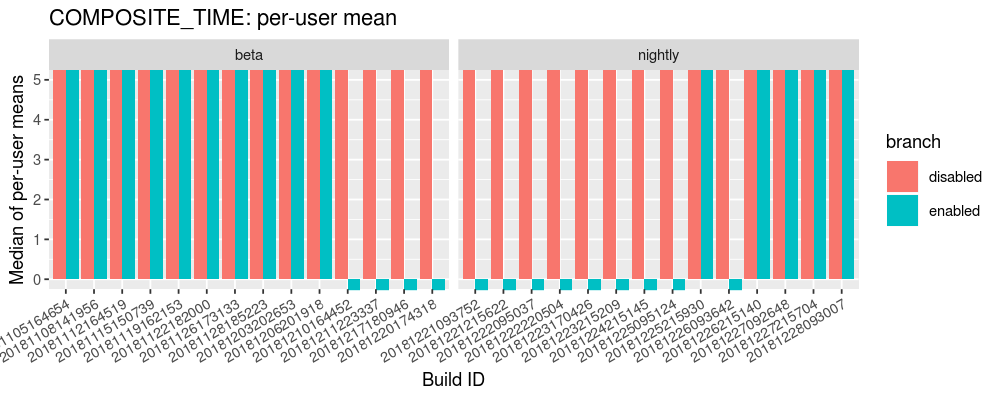

In [34]:
%r
perf_medians %>%
  inner_join(display_builds) %>%
  filter(metric=="composite_time") %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    coord_cartesian(ylim=c(0, 5)) +
    labs(title="COMPOSITE_TIME: per-user mean", x="Build ID", y="Median of per-user means")

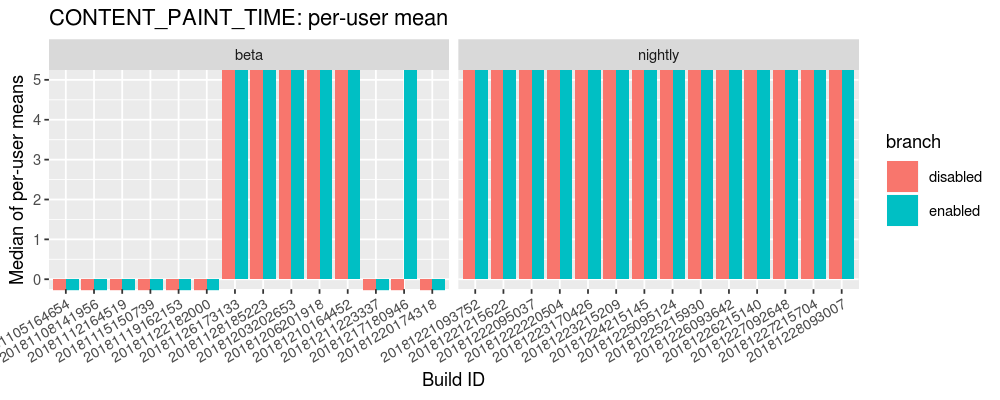

In [35]:
%r
perf_medians %>%
  inner_join(display_builds) %>%
  filter(metric=="content_paint_time") %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    coord_cartesian(ylim=c(0, 5)) +
    labs(title="CONTENT_PAINT_TIME: per-user mean", x="Build ID", y="Median of per-user means")

In [36]:
%r
paint_time_quantiles = tbl(sc, "global_temp.wr_paint_time_quantiles") %>%
  collect %>%
  group_by(app_build_id, normalized_channel, branch, quantile) %>%
  summarize(
    user_median=median(value, na.rm=TRUE),
    log_sd=sd(log10(value+1), na.rm=TRUE),
    log_sem=log_sd/sqrt(n()),
    log_ymin=log10(user_median)-1.96*log_sem,
    log_ymax=log10(user_median)+1.96*log_sem
  )

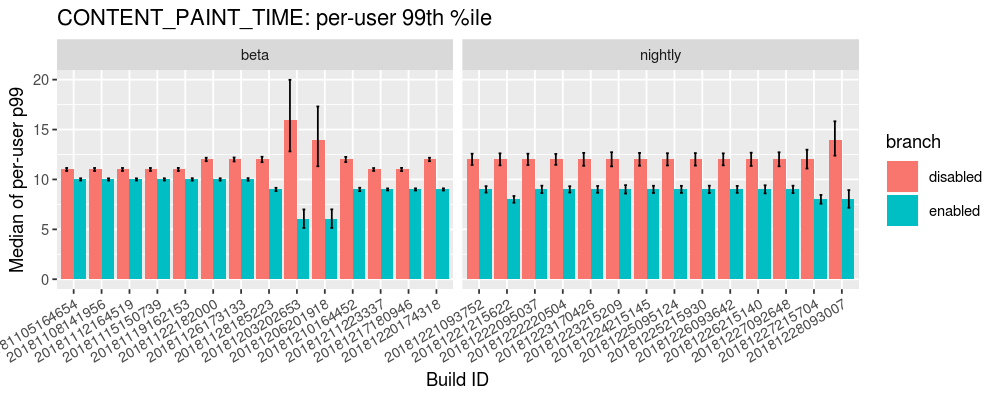

In [37]:
%r
paint_time_quantiles %>%
  inner_join(display_builds) %>%
  filter(quantile == 0.99) %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_PAINT_TIME: per-user 99th %ile", x="Build ID", y="Median of per-user p99")

In [38]:
%r
perf_medians %>% filter(metric=='content_frame_time')

# A tibble: 438 x 9
# Groups: app_build_id, normalized_channel, branch [438]
 app_build_id normalized_chan… branch metric user_median log_sd log_sem
 
 1 20180920220… nightly disab… conte… 1199245 1.39 0.525
 2 20180920220… nightly enabl… conte… 12005100 1.62 0.511
 3 20180921100… nightly disab… conte… 471399 1.46 0.488
 4 20180921100… nightly enabl… conte… 17473496 1.72 0.573
 5 20180921220… nightly disab… conte… 8327764. 1.68 0.532
 6 20180921220… nightly enabl… conte… 7738581 1.67 0.528
 7 20180922100… nightly disab… conte… 7780590. 0.928 0.232
 8 20180922100… nightly enabl… conte… 3421334 0.961 0.192
 9 20180922220… nightly disab… conte… 4358342 1.57 0.435
10 20180922220… nightly enabl… conte… 2730402. 1.30 0.306
# ... with 428 more rows, and 2 more variables: log_ymin , log_ymax

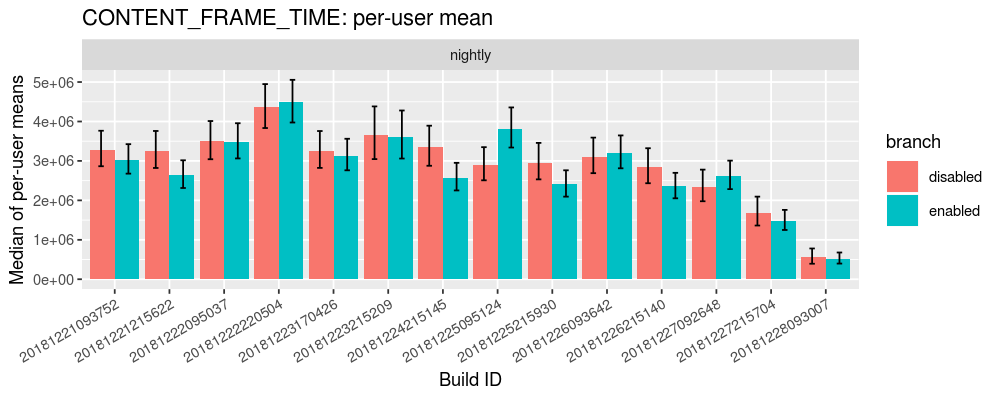

In [39]:
%r
perf_medians %>%
  inner_join(display_builds) %>%
  filter(metric=="content_frame_time") %>%
  filter(normalized_channel=='nightly') %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    #coord_cartesian(ylim=c(0, 10000000)) +
    labs(title="CONTENT_FRAME_TIME: per-user mean", x="Build ID", y="Median of per-user means")

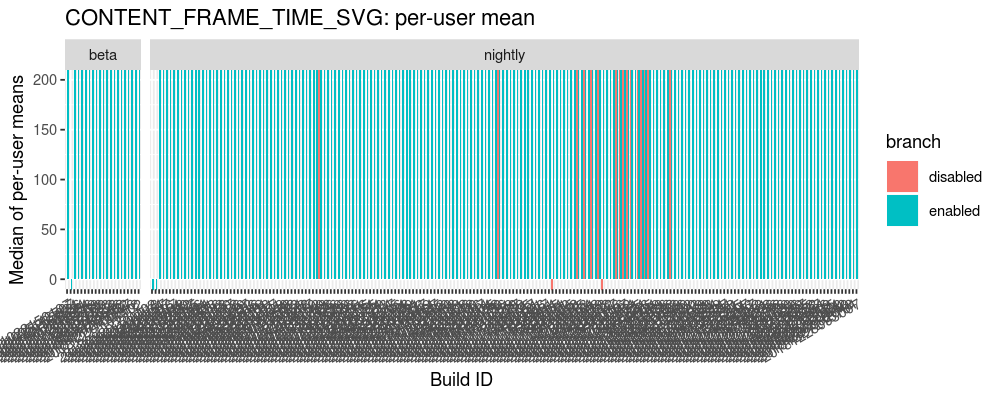

In [40]:
%r
perf_medians %>%
  #inner_join(display_builds) %>%
  filter(metric=="content_frame_time_svg") %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    coord_cartesian(ylim=c(0, 200)) +
    labs(title="CONTENT_FRAME_TIME_SVG: per-user mean", x="Build ID", y="Median of per-user means")

In [41]:
%r
slow_content_frame_time = tbl(sc, "global_temp.wr_slow_content_frame_time") %>% collect

In [42]:
%r
slow_content_frame_boot = function(df) {
  ci = boot(df$fraction_exceeding, function(data, x) median(data[x], na.rm=TRUE), 1000) %>%
     boot.ci(0.95, "basic")
  data.frame(
    ymin=ci$basic[4],
    y=ci$t0,
    ymax=ci$basic[5]
  ) * 100
}

slow_content_frame_time_summary = slow_content_frame_time %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

In [43]:
%r
# Thresholded slow events
# "composite_time", "content_paint_time", "content_full_paint_time"
slow_content_frame_time_svg_summary = tbl(sc, "global_temp.wr_slow_content_frame_time_svg") %>%
  collect %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

[1] "All values of t are equal to 0.0420609884332282 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0438338240104678 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.325654345561426 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.183984070643234 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0179028132992327 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0133057700983792 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0810588756786669 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.00572179506015639 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0510166013803395 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0293558445509164 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.983734593434945 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.00342261634167975 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.00175533035317247 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.00659108884787767 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.00860789551795785 \n Cannot calculate confidence intervals"

In [44]:
%r
# Thresholded slow events
# "composite_time", "content_paint_time", "content_full_paint_time"
slow_content_frame_time_without_upload_summary = tbl(sc, "global_temp.wr_slow_content_frame_time_without_upload") %>%
  collect %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

[1] "All values of t are equal to 0.221987681353476 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0116959064327485 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.404479650368752 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.577590243829921 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.101084585368851 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0519741564967696 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0386936962587552 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.648787215227187 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0848447586842914 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0959214501510574 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.00729684908789386 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.00507965827753406 \n Cannot calculate confidence intervals"

In [45]:
%r
# Thresholded slow events
# "composite_time", "content_paint_time", "content_full_paint_time"
slow_composite_time_summary = tbl(sc, "global_temp.wr_slow_composite_time") %>%
  collect %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

Error : org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1089.0 failed 4 times, most recent failure: Lost task 0.3 in stage 1089.0 (TID 707501, 10.166.248.80, executor 286): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
 File "/databricks/spark/python/pyspark/worker.py", line 372, in main
 process()
 File "/databricks/spark/python/pyspark/worker.py", line 367, in process
 serializer.dump_stream(func(split_index, iterator), outfile)
 File "/databricks/spark/python/pyspark/worker.py", line 243, in <lambda>
 func = lambda _, it: map(mapper, it)
 File "<string>", line 1, in <lambda>
 File "/databricks/spark/python/pyspark/worker.py", line 120, in wrapped
 "Expected: {} Actual: {}".format(len(return_type), len(result.columns)))
RuntimeError: Number of columns of the returned pandas.DataFrame doesn't match specified schema. Expected: 7 Actual: 6

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:469)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:423)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.execution.collect.UnsafeRowBatchUtils$.encodeUnsafeRows(UnsafeRowBatchUtils.scala:51)
	at org.apache.spark.sql.execution.collect.Collector$$anonfun$1.apply(Collector.scala:140)
	at org.apache.spark.sql.execution.collect.Collector$$anonfun$1.apply(Collector.scala:139)
	at org.apache.spark.SparkContext$$anonfun$38.apply(SparkContext.scala:2276)
	at org.apache.spark.SparkContext$$anonfun$38.apply(SparkContext.scala:2276)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:124)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$11.apply(Executor.scala:459)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1401)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:465)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:2025)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:2013)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:2012)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2012)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:1057)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:1057)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2248)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2196)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2184)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:854)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2180)
	at org.ap

In [46]:
%r
slow_content_paint_time_summary = tbl(sc, "global_temp.wr_slow_content_paint_time") %>%
  collect %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

Error : org.apache.spark.SparkException: Job aborted due to stage failure: Task 128 in stage 1107.0 failed 4 times, most recent failure: Lost task 128.3 in stage 1107.0 (TID 710257, 10.166.252.85, executor 270): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
 File "/databricks/spark/python/pyspark/worker.py", line 372, in main
 process()
 File "/databricks/spark/python/pyspark/worker.py", line 367, in process
 serializer.dump_stream(func(split_index, iterator), outfile)
 File "/databricks/spark/python/pyspark/worker.py", line 243, in <lambda>
 func = lambda _, it: map(mapper, it)
 File "<string>", line 1, in <lambda>
 File "/databricks/spark/python/pyspark/worker.py", line 120, in wrapped
 "Expected: {} Actual: {}".format(len(return_type), len(result.columns)))
RuntimeError: Number of columns of the returned pandas.DataFrame doesn't match specified schema. Expected: 7 Actual: 6

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:469)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:423)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.execution.collect.UnsafeRowBatchUtils$.encodeUnsafeRows(UnsafeRowBatchUtils.scala:51)
	at org.apache.spark.sql.execution.collect.Collector$$anonfun$1.apply(Collector.scala:140)
	at org.apache.spark.sql.execution.collect.Collector$$anonfun$1.apply(Collector.scala:139)
	at org.apache.spark.SparkContext$$anonfun$38.apply(SparkContext.scala:2276)
	at org.apache.spark.SparkContext$$anonfun$38.apply(SparkContext.scala:2276)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:124)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$11.apply(Executor.scala:459)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1401)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:465)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:2025)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:2013)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:2012)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2012)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:1057)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:1057)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2248)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2196)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2184)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:854)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2180)
	at or

In [47]:
%r
slow_content_full_paint_time_summary = tbl(sc, "global_temp.wr_slow_content_full_paint_time") %>%
  collect %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

Error : org.apache.spark.SparkException: Job aborted due to stage failure: Task 95 in stage 1101.0 failed 4 times, most recent failure: Lost task 95.3 in stage 1101.0 (TID 709320, 10.166.240.39, executor 309): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
 File "/databricks/spark/python/pyspark/worker.py", line 372, in main
 process()
 File "/databricks/spark/python/pyspark/worker.py", line 367, in process
 serializer.dump_stream(func(split_index, iterator), outfile)
 File "/databricks/spark/python/pyspark/worker.py", line 243, in <lambda>
 func = lambda _, it: map(mapper, it)
 File "<string>", line 1, in <lambda>
 File "/databricks/spark/python/pyspark/worker.py", line 120, in wrapped
 "Expected: {} Actual: {}".format(len(return_type), len(result.columns)))
RuntimeError: Number of columns of the returned pandas.DataFrame doesn't match specified schema. Expected: 7 Actual: 6

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:469)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:423)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.execution.collect.UnsafeRowBatchUtils$.encodeUnsafeRows(UnsafeRowBatchUtils.scala:51)
	at org.apache.spark.sql.execution.collect.Collector$$anonfun$1.apply(Collector.scala:140)
	at org.apache.spark.sql.execution.collect.Collector$$anonfun$1.apply(Collector.scala:139)
	at org.apache.spark.SparkContext$$anonfun$38.apply(SparkContext.scala:2276)
	at org.apache.spark.SparkContext$$anonfun$38.apply(SparkContext.scala:2276)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:124)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$11.apply(Executor.scala:459)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1401)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:465)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:2025)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:2013)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:2012)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2012)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:1057)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:1057)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2248)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2196)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2184)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:854)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2180)
	at org.

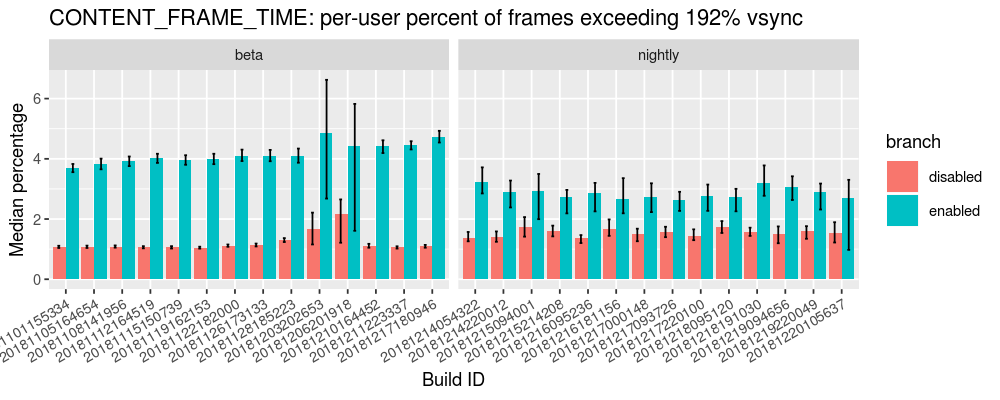

In [48]:
%r
slow_content_frame_time_summary %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME: per-user percent of frames exceeding 192% vsync", x="Build ID", y="Median percentage")

In [49]:
%r
slow_content_frame_time_summary

# A tibble: 404 x 6
# Groups: normalized_channel, app_build_id, branch [404]
 normalized_channel app_build_id branch ymin y ymax
 
 1 beta 20181022150107 disabled 0.973 1.02 1.06
 2 beta 20181022150107 enabled 3.29 3.48 3.66
 3 beta 20181025143507 disabled -0.198 4.68 5.51
 4 beta 20181025143507 enabled -9.73 15.1 29.7 
 5 beta 20181025233934 disabled 1.01 1.05 1.08
 6 beta 20181025233934 enabled 3.66 3.82 3.98
 7 beta 20181029164536 disabled 0.974 1.01 1.05
 8 beta 20181029164536 enabled 3.69 3.84 3.98
 9 beta 20181101155334 disabled 1.04 1.07 1.11
10 beta 20181101155334 enabled 3.56 3.70 3.83
# ... with 394 more rows

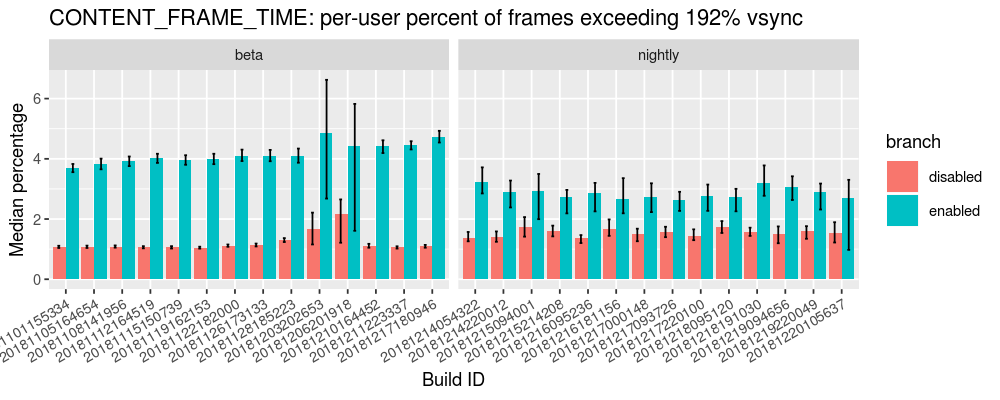

In [50]:
%r
slow_content_frame_time_summary %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME: per-user percent of frames exceeding 192% vsync", x="Build ID", y="Median percentage")

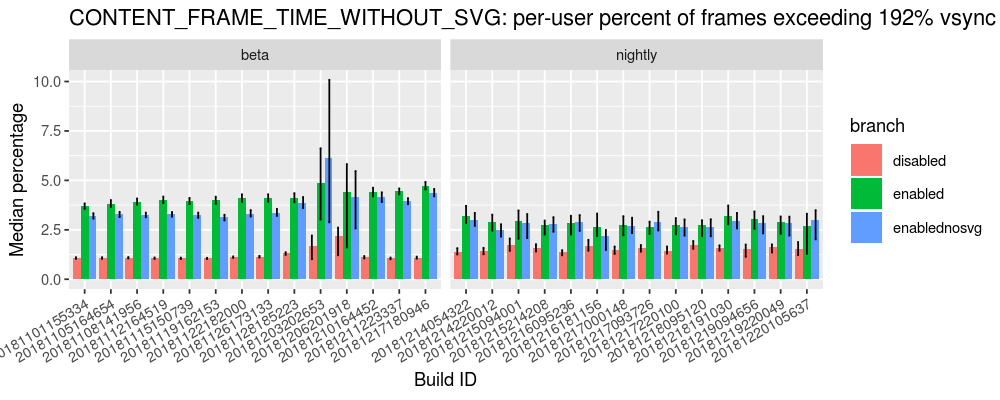

In [51]:
%r
slow_content_frame_time_svg_summary %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME_WITHOUT_SVG: per-user percent of frames exceeding 192% vsync", x="Build ID", y="Median percentage")

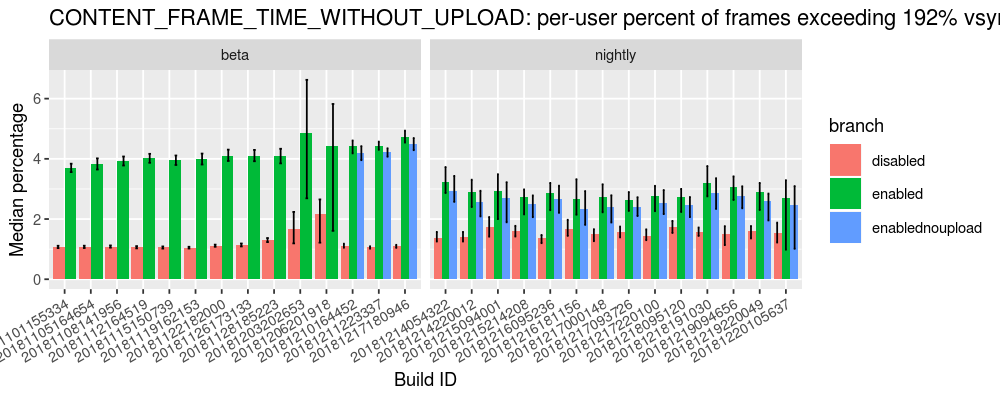

In [52]:
%r
slow_content_frame_time_without_upload_summary %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME_WITHOUT_UPLOAD: per-user percent of frames exceeding 192% vsync", x="Build ID", y="Median percentage")

In [53]:
%r
slow_content_frame_boot_p90 = function(df) {
  ci = boot(df$fraction_exceeding, function(data, x) quantile(data[x], 0.9, na.rm=TRUE), 1000) %>%
     boot.ci(0.95, "basic")
  data.frame(
    ymin=ci$basic[4],
    y=ci$t0,
    ymax=ci$basic[5]
  ) * 100
}

slow_content_frame_time_summary_p90 = slow_content_frame_time %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot_p90(.))

In [54]:
%r
slow_content_frame_time_summary_p90 %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME: per-user percent of frames exceeding 192% vsync", x="Build ID", y="90th percentile percentage")

In [55]:
%r
perf_medians %>%
  inner_join(display_builds) %>%
  filter(metric=="tab_switch_composite") %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="FX_TAB_SWITCH_COMPOSITE_E10S_MS: per-user mean", x="Build ID", y="Median of per-user means")

## Engagement metrics

In [57]:
%r
engagement = metrics %>%
  group_by(client_id, app_build_id, normalized_channel, branch) %>%
  summarize(
    hours=sum(subsession_length)/3600,
    active_hours=sum(active_ticks)*5/3600,
    uris=sum(total_uris)
  ) %>%
  mutate(
    intensity=active_hours/hours,
    uris_per_active_hour=uris/active_hours
  ) %>%
  collect

In [58]:
%r
uri_summary = engagement %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  summarize(
    user_median=median(uris_per_active_hour, na.rm=TRUE),
    log_sd=sd(log10(uris_per_active_hour), na.rm=TRUE),
    log_sem=log_sd/sqrt(n()),
    log_ymin=log10(user_median)-1.96*log_sem,
    log_ymax=log10(user_median)+1.96*log_sem
  )

In [59]:
%r
uri_summary %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(x="Build ID", y="Median", title="URI count per active hour")

In [60]:
%r
intensity_boot = function(df) {
  ci = boot(df$intensity, function(data, x) median(data[x], na.rm=TRUE), 1000) %>%
     boot.ci(0.95, "basic")
  data.frame(
    ymin=ci$basic[4],
    y=ci$t0,
    ymax=ci$basic[5]
  ) * 100
}

intensity_summary = engagement %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(intensity_boot(.))

In [61]:
%r
intensity_summary %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(x="Build ID", y="Median", title="Median session intensity (percent)")

In [62]:
%r
head(intensity_summary)